In [8]:
import numpy as np
import pandas as pd
import faiss
from sklearn.metrics.pairwise import manhattan_distances as dist
from math import e
import random

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn.datasets import load_iris

import cv2 as cv
from skimage import io, color
from skimage.transform import resize

In [14]:
def lshqs(xb,h=None,_nbits=None):
	d=len(xb[0])
	n=len(xb)
	if(h==None):
		h=1.06*(n**-0.2)
	if(_nbits==None):
		_nbits=d
	index = faiss.IndexLSH(d,_nbits)
	index.train(xb)
	index.add(xb)
	k=4
	D, I = index.search(xb, k)

	kde=[0]*n
	for i,x in enumerate(xb):
		kde[i]=sum([e**(-D[i][j]/h) for j in range(k)])

	def argmax(lst):
		return max(range(len(lst)), key=lst.__getitem__)

	g=[set([i]) for i in range(n)]
	for i in range(n):
		u=I[i][argmax([kde[x] for x in I[i]])]
		g[u].add(i)
		g[i].add(u)

	c=[-1]*n
	def dfs(u,t):
		c[u]=t
		for v in g[u]:
			if(c[v]==-1):
				dfs(v,t)

	T=0
	for i in range(n):
		if(c[i]==-1):
			dfs(i,T)
			T+=1

	return c

In [ ]:
def lshms(xb,h=None,_nbits=None):
	d=len(xb[0])
	n=len(xb)
	if(h==None):
		h=1.06*(n**-0.2)
	if(_nbits==None):
		_nbits=d
	index = faiss.IndexLSH(d,_nbits)
	index.train(xb)
	index.add(xb)
	k=4
	D, I = index.search(xb, k)

	kde=[0]*n
	for i,x in enumerate(xb):
		kde[i]=sum([e**(-D[i][j]/h) for j in range(k)])

	def argmax(lst):
		return max(range(len(lst)), key=lst.__getitem__)

	g=[set([i]) for i in range(n)]
	for i in range(n):
		u=I[i][argmax([kde[x] for x in I[i]])]
		g[u].add(i)
		g[i].add(u)

	c=[-1]*n
	def dfs(u,t):
		c[u]=t
		for v in g[u]:
			if(c[v]==-1):
				dfs(v,t)

	T=0
	for i in range(n):
		if(c[i]==-1):
			dfs(i,T)
			T+=1

	return c

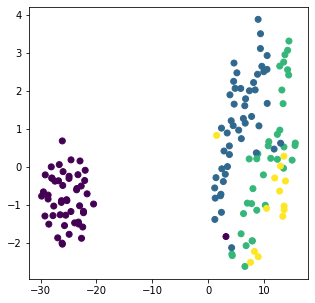

Number of clusters found:  4


In [21]:
data=load_iris()
xb=data.data
c=lshqs(xb,None,10)

df = StandardScaler().fit_transform(xb)
tsne = TSNE(init='pca', learning_rate='auto').fit_transform(df)
_X = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])
plt.rcParams["figure.figsize"] = (5, 5)
plt.scatter(_X['tsne1'], _X['tsne2'], c=c)
plt.show()
print("Number of clusters found: ",max(c)+1)

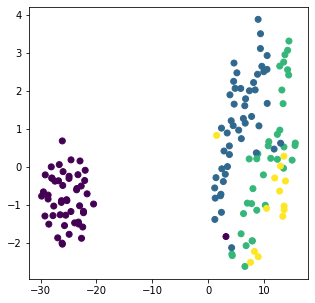

Number of clusters found:  4


In [7]:
c=lshqs(xb)
plt.scatter(_X['tsne1'], _X['tsne2'], c=c)
plt.show()
print("Number of clusters found: ",max(c)+1)

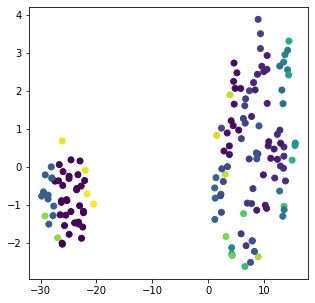

Number of clusters found:  31


In [8]:
h=1.06*(len(xb)**-0.2)
clustering = MeanShift(bandwidth=h).fit(xb)
plt.scatter(_X['tsne1'], _X['tsne2'], c=clustering.labels_)
plt.show()
print("Number of clusters found: ",max(clustering.labels_))

In [9]:
image_path = "./1.jpeg"
img = cv.imread(image_path)
img = cv.medianBlur(img, 3)
flat_image = img.reshape((-1,3))
flat_image = np.float32(flat_image)

# image = resize(image, (100, 100))
# image_flat = image.reshape((-1, image.shape[-1]))

c=lshqs(flat_image)
print("Number of clusters found: ",max(c)+1)

Number of clusters found:  7


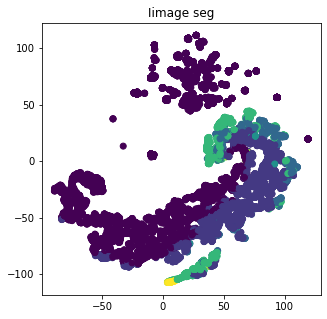

In [10]:
df = StandardScaler().fit_transform(flat_image)
tsne = TSNE(init='pca', learning_rate='auto').fit_transform(df)
_X = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

plt.rcParams["figure.figsize"] = (5, 5)
plt.scatter(_X['tsne1'], _X['tsne2'], c=c)
plt.title("Iimage seg")
plt.show()

In [13]:
# get number of segments
segments = np.unique(c)
print('Number of segments: ', segments.shape[0])

# get the average color of each segment
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
print('Number of points: ', total.shape)

for i, label in enumerate(c):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)

# cast the labeled image into the corresponding average color
res = avg[c]
result = res.reshape((img.shape))

print('Number of points: ', img.shape)

# show the result
cv.imshow('result',result)
cv.waitKey(0)
cv.destroyAllWindows()

Number of segments:  7
Number of points:  (7, 3)
Number of points:  (127, 192, 3)
